# **<a id="Content">HnM RecSys Notebook 9417</a>**

## **<a id="Content">Table of Contents</a>**
* [**<span>1. Imports</span>**](#Imports)  
* [**<span>2. Pre-Processing</span>**](#Pre-Processing)
* [**<span>3. Exploratory Data Analysis</span>**](#Exploratory-Data-Analysis)  
    * [**<span>3.1 Articles</span>**](#EDA::Articles)  
    * [**<span>3.2 Customers</span>**](#EDA::Customers)
    * [**<span>3.3 Transactions</span>**](#EDA::Transactions)

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
import re
import warnings
# import cudf # switch on P100 GPU for this to work in Kaggle
# import cupy as cp

# Importing data
articles = pd.read_csv('articles.csv')
print(articles.head())
print("--")
customers = pd.read_csv('customers.csv')
print(customers.head())
print("--")
transactions = pd.read_csv("transactions_train.csv")
print(transactions.head())
print("--")

   article_id  product_code          prod_name  product_type_no   
0   108775015        108775          Strap top              253  \
1   108775044        108775          Strap top              253   
2   108775051        108775      Strap top (1)              253   
3   110065001        110065  OP T-shirt (Idro)              306   
4   110065002        110065  OP T-shirt (Idro)              306   

  product_type_name  product_group_name  graphical_appearance_no   
0          Vest top  Garment Upper body                  1010016  \
1          Vest top  Garment Upper body                  1010016   
2          Vest top  Garment Upper body                  1010017   
3               Bra           Underwear                  1010016   
4               Bra           Underwear                  1010016   

  graphical_appearance_name  colour_group_code colour_group_name  ...   
0                     Solid                  9             Black  ...  \
1                     Solid               

## Pre-Processing

In [2]:
# ----- empty value stats -------------
print("Missing values: ")
print(customers.isnull().sum())
print("--\n")

print("FN Newsletter vals: ", customers['FN'].unique())
print("Active communication vals: ",customers['Active'].unique())
print("Club member status vals: ", customers['club_member_status'].unique())
print("Fashion News frequency vals: ", customers['fashion_news_frequency'].unique())
print("--\n")

# ---- data cleaning -------------

customers['FN'] = customers['FN'].fillna(0)
customers['Active'] = customers['Active'].fillna(0)

# replace club_member_status missing values with 'LEFT CLUB' --> no members with LEFT CLUB status in data
customers['club_member_status'] = customers['club_member_status'].fillna('LEFT CLUB')
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].fillna('None')
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].replace('NONE', 'None')
customers['age'] = customers['age'].fillna(customers['age'].mean())
customers['age'] = customers['age'].astype(int)
articles['detail_desc'] = articles['detail_desc'].fillna('None')


print("Customers' Missing values: ")
print(customers.isnull().sum())
print("--\n")

Missing values: 
customer_id                    0
FN                        895050
Active                    907576
club_member_status          6062
fashion_news_frequency     16011
age                        15861
postal_code                    0
dtype: int64
--

FN Newsletter vals:  [nan  1.]
Active communication vals:  [nan  1.]
Club member status vals:  ['ACTIVE' nan 'PRE-CREATE' 'LEFT CLUB']
Fashion News frequency vals:  ['NONE' 'Regularly' nan 'Monthly']
--

Customers' Missing values: 
customer_id               0
FN                        0
Active                    0
club_member_status        0
fashion_news_frequency    0
age                       0
postal_code               0
dtype: int64
--



In [3]:
# ---- memory optimizations -------------

# reference: https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65

# iterate through all the columns of a dataframe and reduce the int and float data types to the smallest possible size, ex. customer_id should not be reduced from int64 to a samller value as it would have collisions
import numpy as np
import pandas as pd

def reduce_mem_usage(df):
    """Iterate over all the columns of a DataFrame and modify the data type
    to reduce memory usage, handling ordered Categoricals"""
    
    # check the memory usage of the DataFrame
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type == 'category':
            if df[col].cat.ordered:
                # Convert ordered Categorical to an integer
                df[col] = df[col].cat.codes.astype('int16')
            else:
                # Convert unordered Categorical to a string
                df[col] = df[col].astype('str')
        
        elif col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    
    # check the memory usage after optimization
    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))

    # calculate the percentage of the memory usage reduction
    mem_reduction = 100 * (start_mem - end_mem) / start_mem
    print("Memory usage decreased by {:.1f}%".format(mem_reduction))
    
    return df

   

In [4]:
print("Articles Info: ")
print(articles.info())
print("Customer Info: ")
print(customers.info())
print("Transactions Info: ")
print(transactions.info())

Articles Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-n

In [5]:
# ---- memory optimizations -------------

# uses 8 bytes instead of given 64 byte string, reduces mem by 8x, 
# !!!! have to convert back before merging w/ sample_submissions.csv
# convert transactions['customer_id'] to 8 bytes int
# transactions['customer_id'] = transactions['customer_id'].astype('int64')
transactions['customer_id'] = transactions['customer_id'].apply(lambda x: int(x[-16:], 16)).astype('int64')
customers['customer_id'] = customers['customer_id'].apply(lambda x: int(x[-16:], 16)).astype('int64')

articles = reduce_mem_usage(articles)
customers = reduce_mem_usage(customers)
transactions = reduce_mem_usage(transactions)

# articles['article_id'] = articles['article_id'].astype('int32')
# transactions['article_id'] = transactions['article_id'].astype('int32') 
# # !!!! ADD LEADING ZERO BACK BEFORE SUBMISSION OF PREDICTIONS TO KAGGLE: 
# # Ex.: transactions['article_id'] = '0' + transactions.article_id.astype('str')

print("Articles Info: ")
print(articles.info())
print("Customer Info: ")
print(customers.info())
print("Transactions Info: ")
print(transactions.info())

Memory usage of dataframe is 20.13 MB
Memory usage after optimization is: 13.59 MB
Memory usage decreased by 32.5%
Memory usage of dataframe is 68.04 MB
Memory usage after optimization is: 48.41 MB
Memory usage decreased by 28.8%
Memory usage of dataframe is 1212.63 MB
Memory usage after optimization is: 697.26 MB
Memory usage decreased by 42.5%
Articles Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int32 
 1   product_code                  105542 non-null  int32 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int16 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  i

## Exploratory-Data-Analysis

### EDA::Articles

<b>Article data:</b>

`article_id` : Unique id for every article of clothing<br>

Observing the structure of the column info, this indentation structure of features satisfied article identification: <br>

- `<index_group_no>` and `<index_group_name>` :: <b>(clothing categories)</b>
	- `<index_name>` and `<index_group_no>` :: <b>(clothing categories' sub-groups) -- same as index group if no subgroups for a category</b>
		- `<section_name>` and `<section_no>` :: <b>(clothing collections)</b>
			- `<garment_group_name>` and `<garment_group_no>` :: <b>(garment groups)</b>
				- `<product_group_name>` and `<product_group_no>` :: <b>(product groups)</b>
					- `<product_type_name>` and `<prod_type_no>` :: <b>(product types)</b>
						- `<product_code>` and `<prod_name>` :: <b>(product names)</b>

Other data: <br>
`colour_*`: colour info of each article                    
`perceived_colour_*`: colour info of each article<br>
`department_*`: department info<br>
`detail_desc`: article description<br>
(we're ignoring `graphical_*` features since we are not going to use the image data)


In [6]:
articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


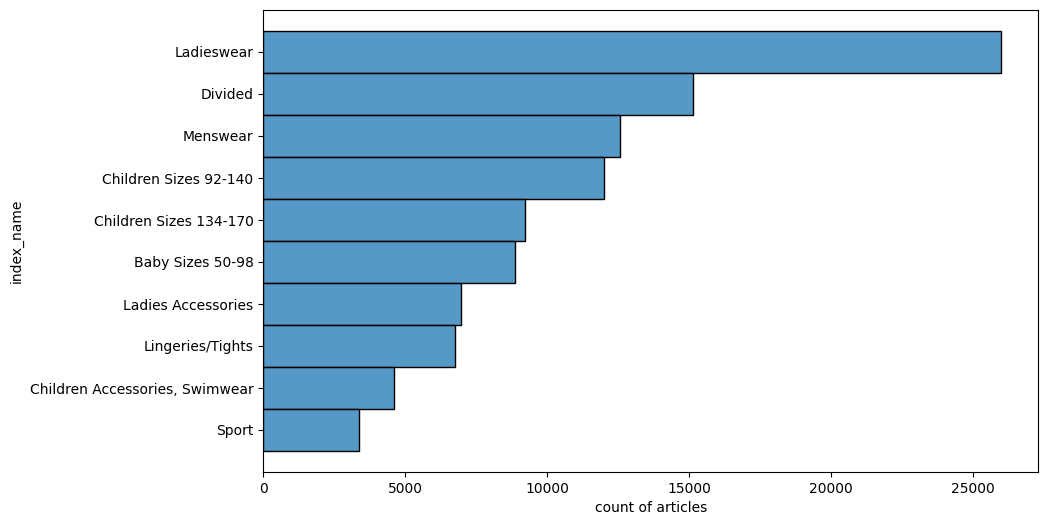

In [7]:
# Observing the most popular clothing categories (indices)

# Convert index_name to ordered categorical for ordered histplot
ordered_index_names = articles['index_name'].value_counts().index
articles['index_name'] = pd.Categorical(articles['index_name'], categories=ordered_index_names, ordered=True)

# Plot histogram
f, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=articles, y='index_name')
ax.set_xlabel('count of articles')
ax.set_ylabel('index_name')
plt.show()

The Ladieswear category and Children (aggregated) category have the most articles. The Sport category has the least articles.

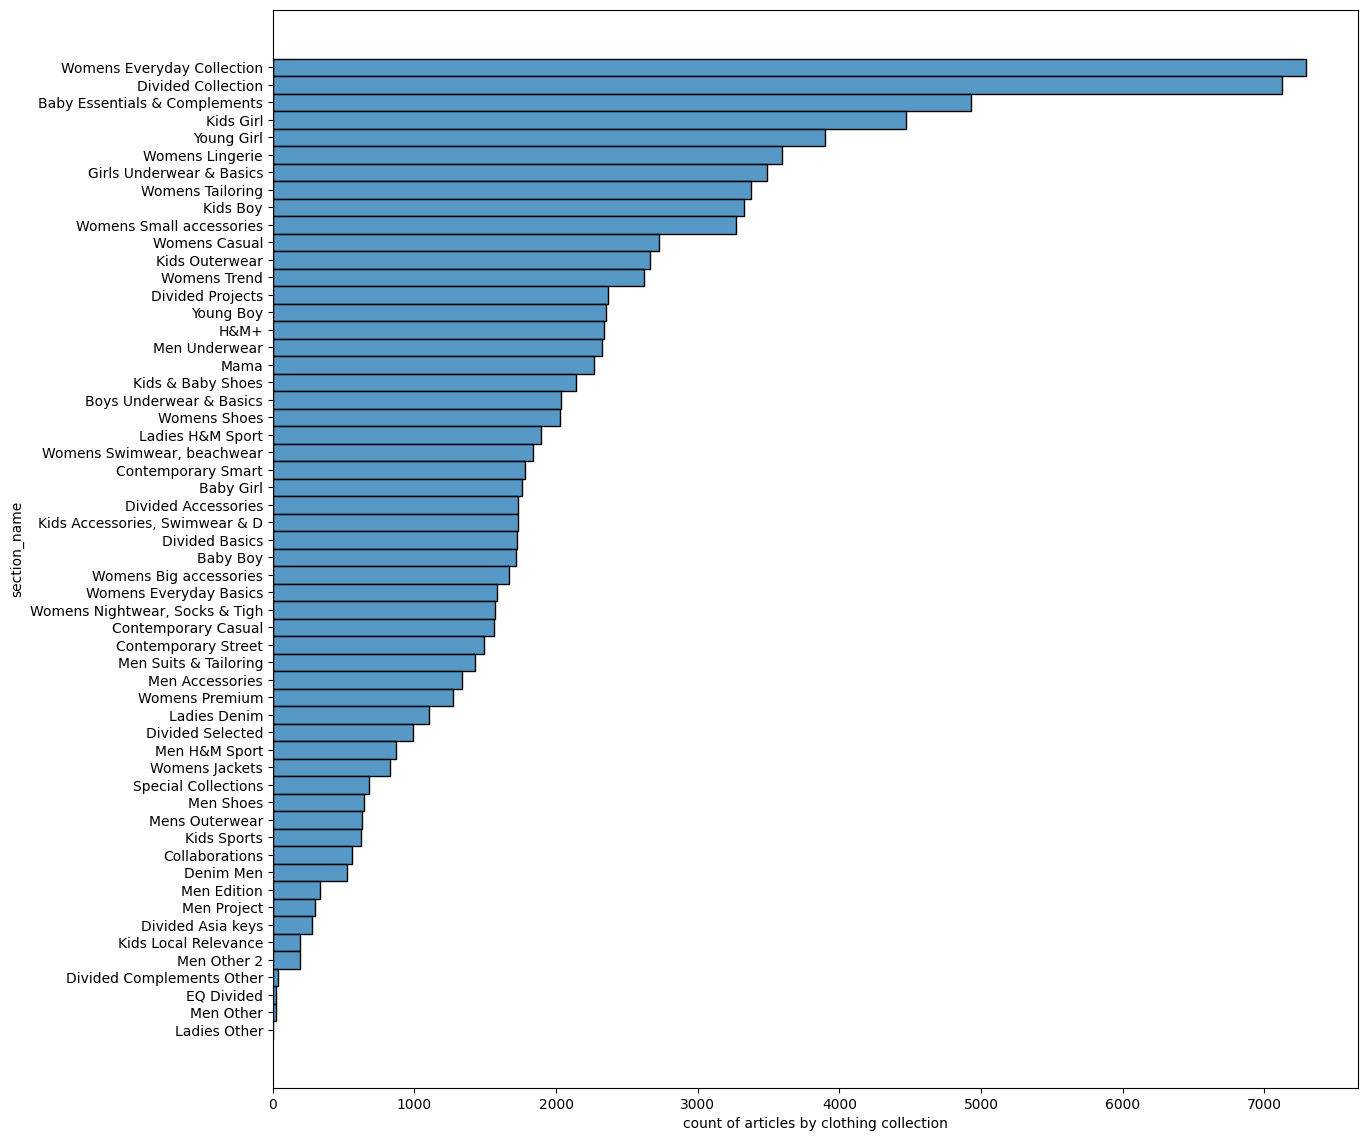

In [8]:
# Observing the most popular clothing collections (sections)

ordered_section_names = articles['section_name'].value_counts().index
articles['section_name'] = pd.Categorical(articles['section_name'], categories=ordered_section_names, ordered=True)

f, ax = plt.subplots(figsize=(14, 14))
sns.histplot(data=articles, y='section_name', bins=len(ordered_section_names))
ax.set_xlabel('count of articles by clothing collection')
ax.set_ylabel('section_name')
plt.show()

Women's Everyday Collection, followed by the miscellaneous section Divided Collection, and Baby Essentials & Complements.
Ladies Other has the least number of articles.

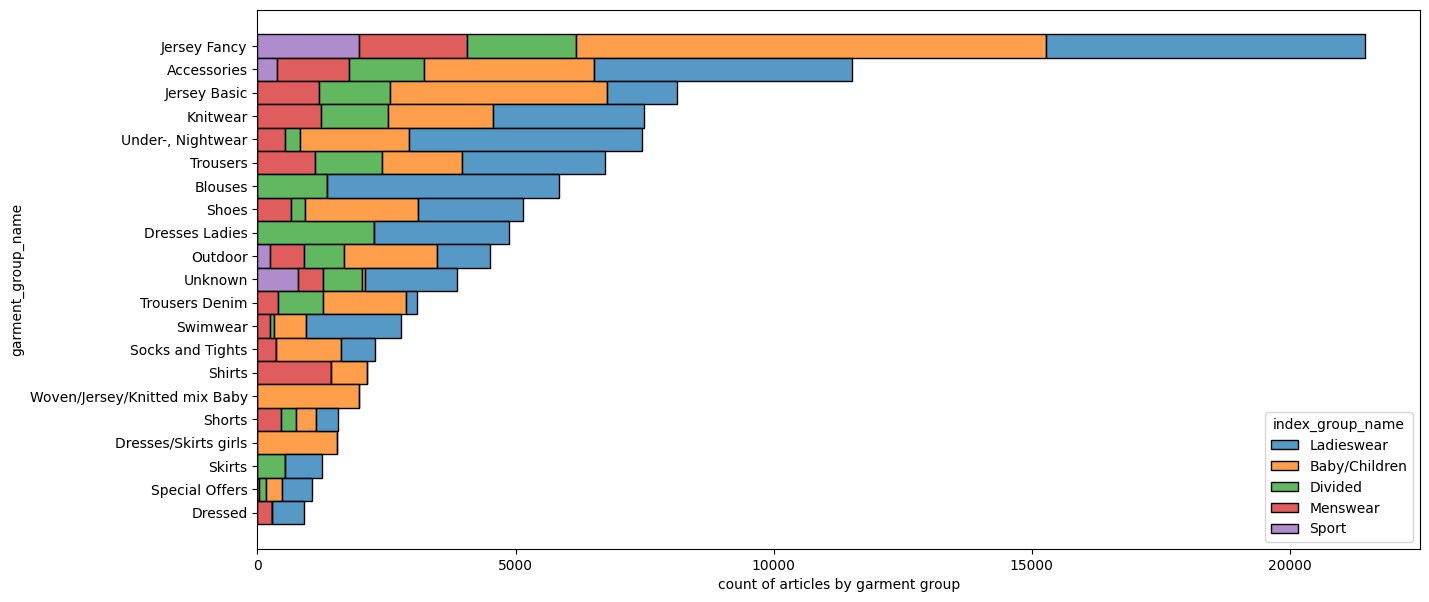

In [9]:
# Observing garments grouped by their clothing category (index_group)

ordered_garment_group_names = articles['garment_group_name'].value_counts().index
ordered_index_group_names = articles['index_group_name'].value_counts().index
articles['garment_group_name'] = pd.Categorical(articles['garment_group_name'], categories=ordered_garment_group_names, ordered=True)
articles['index_group_name'] = pd.Categorical(articles['index_group_name'], categories=ordered_index_group_names, ordered=True)

f, ax = plt.subplots(figsize=(15, 7))
ax = sns.histplot(data=articles, y='garment_group_name', hue='index_group_name', multiple="stack")
ax.set_xlabel('count of articles by garment group')
ax.set_ylabel('garment_group_name')
plt.show()


Jersey Fancy and Accessories are the most popular garment groups; a large part of the Ladieswear and Children categories contribute to the garment group counts.

In [10]:
# Observing number of articles per clothing category

articles.groupby(['index_group_name']).count()['article_id']

index_group_name
Ladieswear       39737
Baby/Children    34711
Divided          15149
Menswear         12553
Sport             3392
Name: article_id, dtype: int64

In [11]:
# Since some clothing categories (index_group_name) have sub-categories (index_name):
# Observing number of articles per sub-category

grouped_counts = articles.groupby(['index_group_name', 'index_name']).count()['article_id']
grouped_counts = grouped_counts[grouped_counts != 0]
grouped_counts

index_group_name  index_name                    
Ladieswear        Ladieswear                        26001
                  Ladies Accessories                 6961
                  Lingeries/Tights                   6775
Baby/Children     Children Sizes 92-140             12007
                  Children Sizes 134-170             9214
                  Baby Sizes 50-98                   8875
                  Children Accessories, Swimwear     4615
Divided           Divided                           15149
Menswear          Menswear                          12553
Sport             Sport                              3392
Name: article_id, dtype: int64

The clothing sub-catgeory of Ladieswear in the Ladieswear category has the most articles.<br>
The clothing sub-catgeory of Children Sizes 92-140 in the Baby/Children category has the most articles in the category.

In [12]:
# Observing number of articles by product group
grouped_counts = articles.groupby(['garment_group_name', 'product_group_name']).count()['article_id']
grouped_counts = grouped_counts[grouped_counts != 0]
grouped_counts

garment_group_name  product_group_name
Jersey Fancy        Accessories              43
                    Garment Full body      3384
                    Garment Lower body     3179
                    Garment Upper body    14356
                    Nightwear                82
                                          ...  
Special Offers      Swimwear                  8
                    Underwear                 7
Dressed             Garment Full body         2
                    Garment Upper body      905
                    Unknown                   1
Name: article_id, Length: 121, dtype: int64

In [13]:
# Observing number of articles by product groups

grouped_counts = articles.groupby(['product_group_name', 'product_type_name']).count()['article_id']
grouped_counts = grouped_counts[grouped_counts != 0]
grouped_counts

product_group_name   product_type_name
Accessories          Accessories set         7
                     Alice band              6
                     Baby Bib                3
                     Bag                  1280
                     Beanie                 56
                                          ... 
Underwear            Underwear corset        7
                     Underwear set          47
Underwear/nightwear  Sleep Bag               6
                     Sleeping sack          48
Unknown              Unknown               121
Name: article_id, Length: 132, dtype: int64

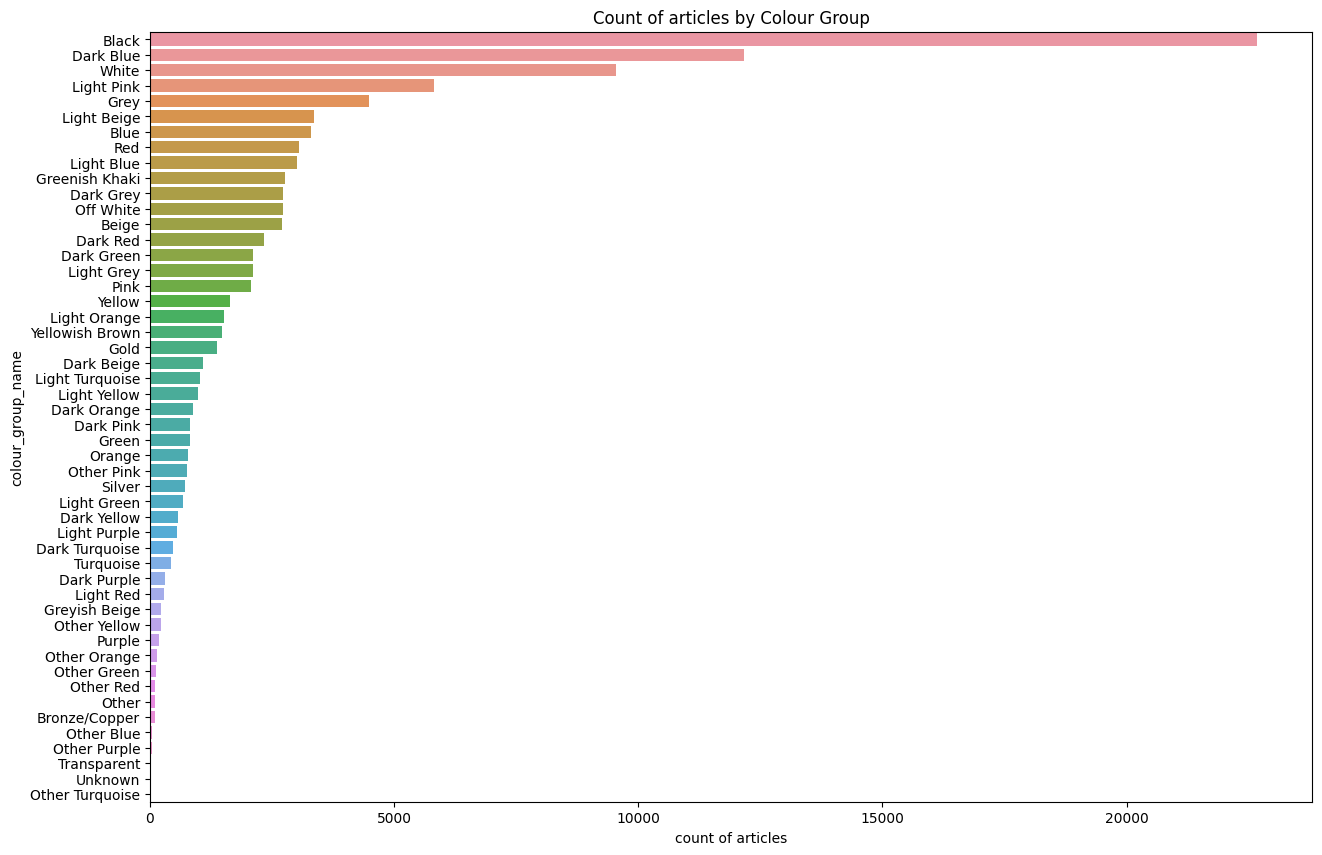

In [14]:
# Observing the most popular colours for articles

ordered_colour_names = articles['colour_group_name'].value_counts().index
articles['colour_group_name'] = pd.Categorical(articles['colour_group_name'], categories=ordered_colour_names, ordered=True)

f, ax = plt.subplots(figsize=(15, 10))
sns.countplot(y='colour_group_name', data=articles, order=ordered_colour_names)
ax.set_xlabel('count of articles')
ax.set_ylabel('colour_group_name')
ax.set_title('Count of articles by Colour Group')
plt.show()

Black, dark blue and white are the most popular colours overall.

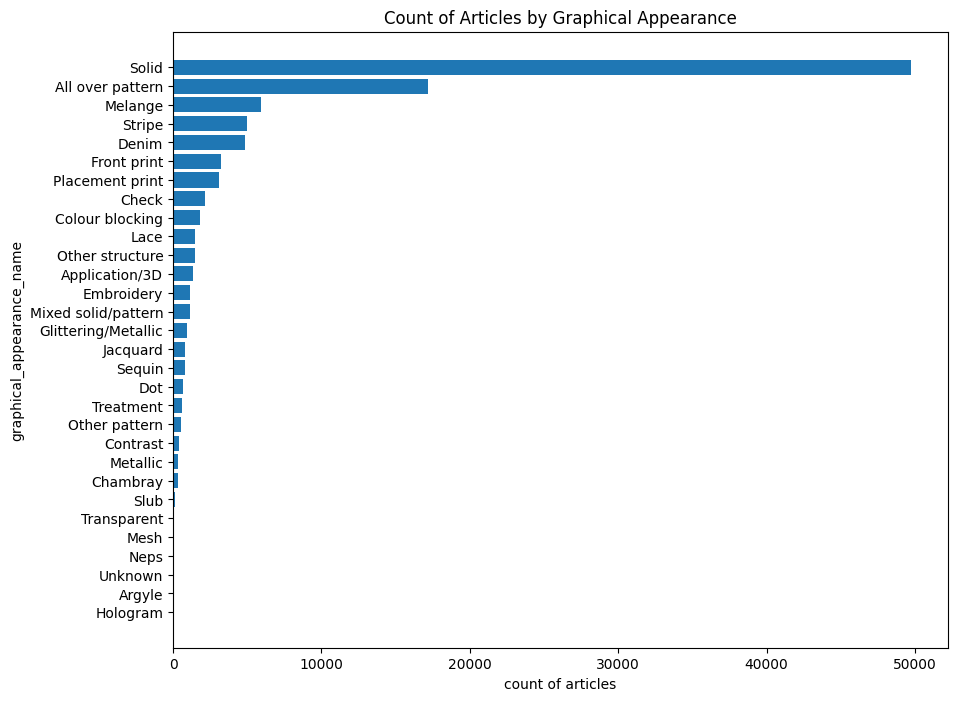

In [15]:
# Observing the most popular graphics for articles

count_by_graphical_appearance = articles['graphical_appearance_name'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(count_by_graphical_appearance.index, count_by_graphical_appearance.values)
ax.set_title('Count of Articles by Graphical Appearance')
ax.set_xlabel('count of articles')
ax.set_ylabel('graphical_appearance_name')
plt.show()

A Solid pattern on articles is most popular.

### EDA::Customers

<b>Customer data:</b>

`customer_id` : Unique id for every customer<br>
`FN` (Does the customer receive fashion news): 1 or 0 <br>
`Active` (Is the customer active for communication): 1 or 0<br>
`club_member_status` (Customer's club status): 'ACTIVE' or 'PRE-CREATE' or 'LEFT CLUB'<br>
`fashion_news_frequency` (How often H&M may send news to customer): 'Regularly' or 'Monthly' or 'None'<br>
`age` : Customer's age<br>
`postal_code` : Customer's postal code<br>

In [16]:
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,6883939031699146327,0.0,0.0,ACTIVE,None,49,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,-7200416642310594310,0.0,0.0,ACTIVE,None,25,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,-6846340800584936,0.0,0.0,ACTIVE,None,24,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,-94071612138601410,0.0,0.0,ACTIVE,None,54,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,-283965518499174310,1.0,1.0,ACTIVE,Regularly,52,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [17]:
# Observing postal code counts

top_5_postal_codes = customers['postal_code'].value_counts().head(5)
print(top_5_postal_codes)

postal_code
2c29ae653a9282cce4151bd87643c907644e09541abc28ae87dea0d1f6603b1c    120303
cc4ed85e30f4977dae47662ddc468cd2eec11472de6fac5ec985080fd92243c8       261
714976379549eb90aae4a71bca6c7402cc646ae7c40f6c1cb91d4b5a18623fc1       159
7c1fa3b0ec1d37ce2c3f34f63bd792f3b4494f324b6be5d1e4ba6a75456b96a7       157
5b7eb31eabebd3277de632b82267286d847fd5d44287ee150bb4206b48439145       156
Name: count, dtype: int64


Clearly, the most common postal code is either some default postal code or a centralized delivery location.

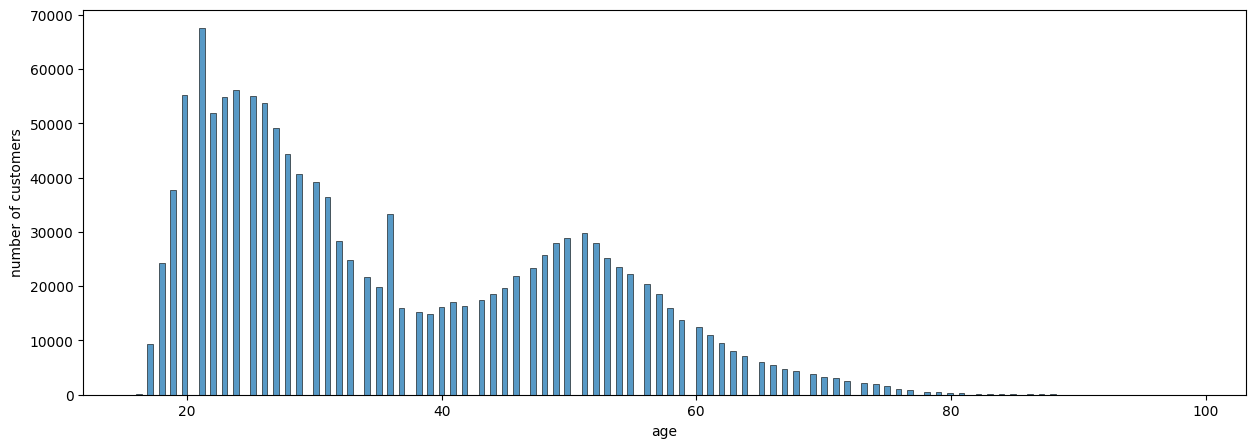

In [18]:
# Observing the customer age distribution

f, ax = plt.subplots(figsize=(15,5))
sns.histplot(data=customers, x='age')
ax.set_ylabel('number of customers')
plt.show()

In [19]:
top_5_ages = customers['age'].value_counts().head(5)
print(top_5_ages)

age
21    67530
24    56124
20    55196
25    54989
23    54867
Name: count, dtype: int64


Clearly, the age range of 20-25 has the most customers.

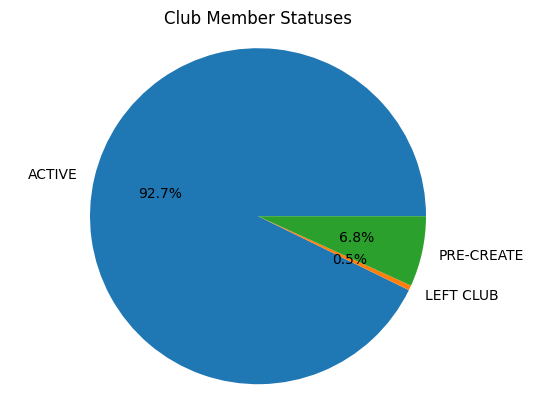

In [20]:
# Observing the club member status of customers

# Group the customers by club member status and count the number of customers in each group
club_member_counts = customers.groupby('club_member_status')['customer_id'].count()

# Pie chart
plt.pie(club_member_counts.values, labels=club_member_counts.index, autopct='%1.1f%%')
plt.title('Club Member Statuses')
plt.axis('equal')
plt.show()

An overwhelming majority of customers currently have an active club status.

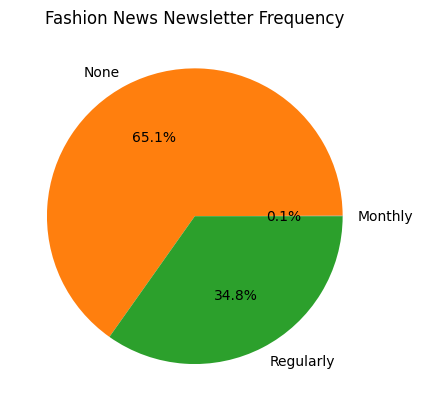

In [21]:
# Observing the FN subscription of customers

news_frequency_counts = customers.groupby('fashion_news_frequency')['customer_id'].count()

# create a pie chart
plt.pie(news_frequency_counts, labels=news_frequency_counts.index, autopct='%1.1f%%')
plt.title('Fashion News Newsletter Frequency')
plt.show()

A majority of customers don't subsribe to the fashion newsletter.

### EDA::Transactions

<b>Transaction data:</b>

`t_dat`: date the transaction occured in yyyy-mm-dd format <br>
`customer_id`: in customers df <br>
`article_id` in articles df <br>
`price`: geneneralized price (not a currency or unit) <br>
`sales_channel_id`: 1 = in-store or 2 = online <br>

In [22]:
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,-6846340800584936,663713001,0.050842,2
1,2018-09-20,-6846340800584936,541518023,0.030487,2
2,2018-09-20,-8334631767138808638,505221004,0.015236,2
3,2018-09-20,-8334631767138808638,685687003,0.016937,2
4,2018-09-20,-8334631767138808638,685687004,0.016937,2


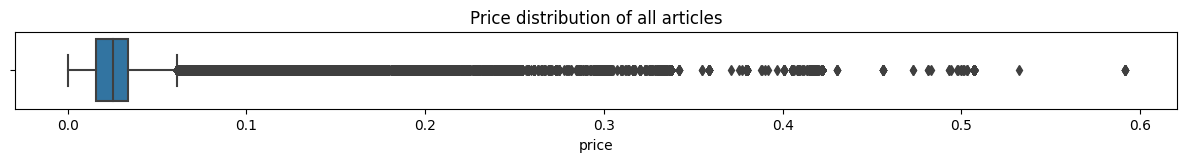

count   31788324.0000
mean              NaN
std            0.0000
min            0.0000
25%            0.0158
50%            0.0254
75%            0.0339
max            0.5913
Name: price, dtype: float64

In [23]:
f, ax = plt.subplots(figsize=(15,1))
ax.set_title('Price distribution of all articles')
sns.boxplot(x='price', data=transactions)
plt.show()
pd.set_option('display.float_format', '{:.4f}'.format)
transactions.describe()['price']

The prices seem to vary a lot across all articles, so the above plot doesn't give us useful information. <br>
The total transaction count is ~31 million, so we'll use a 100,000 sample from the transaction data as needed.

In [24]:
# merging transactions and artciles df on aritcle_id

articles_product_columns = articles[['article_id', 'index_name', 'product_group_name', 'product_type_name', 'prod_name']]
# merged_table_ta --> merged_table_transactions_articles
merged_table_ta = transactions[['customer_id', 'article_id', 'price', 'sales_channel_id','t_dat']].merge(articles_product_columns, on='article_id', how='left')


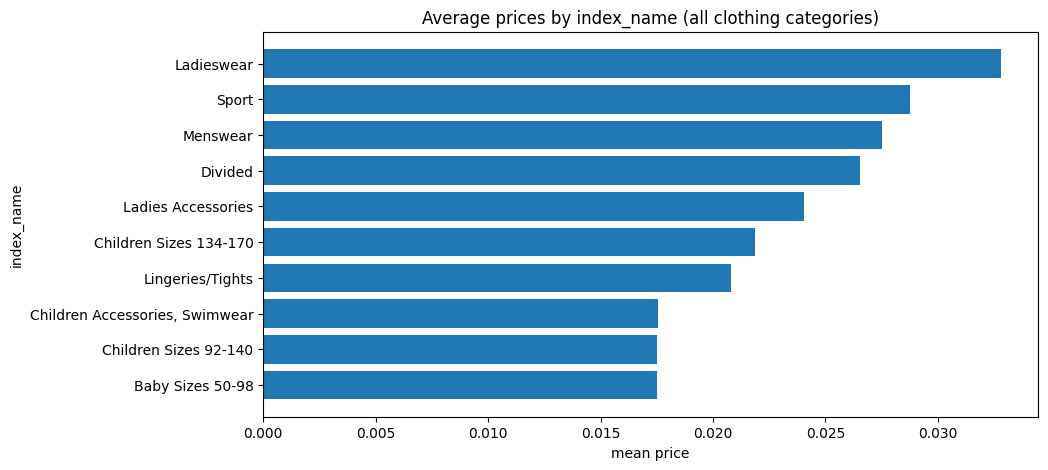

In [25]:
# Observing the mean price of each sub-clothing catgeory (index_name)

# Group the data by index_name and calculate the mean price for each group
price_by_index_name = merged_table_ta.groupby('index_name')['price'].mean()
price_by_index_name = price_by_index_name.sort_values(ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(price_by_index_name.index, price_by_index_name.values)
ax.set_title('Average prices by index_name (all clothing categories)')
ax.set_xlabel('mean price')
ax.set_ylabel('index_name')
plt.show()

The Ladieswear sub-category in the Ladieswear category has the largest mean price.

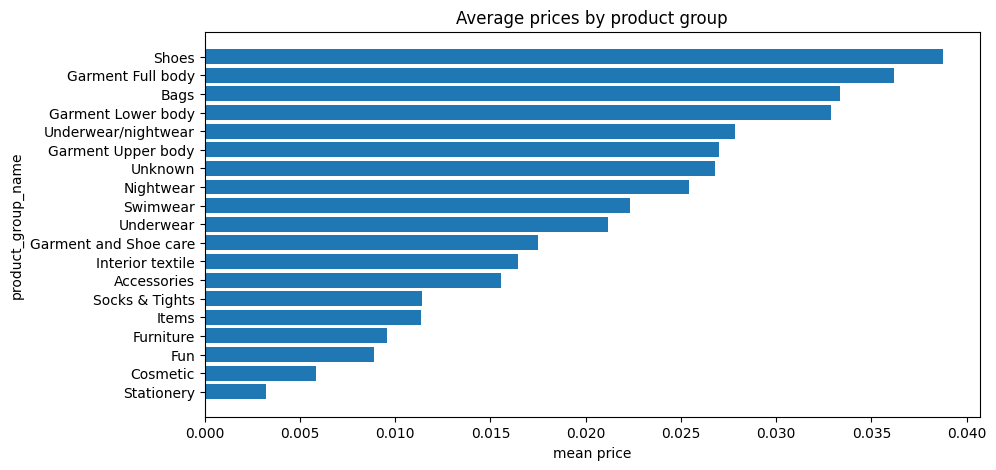

In [26]:
# Observing the mean price of each product group

# Group the data by product_group_name and calculate the mean price for each group
price_by_product_group = merged_table_ta[['product_group_name', 'price']].groupby('product_group_name').mean()
price_by_product_group = price_by_product_group.sort_values(by='price', ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(price_by_product_group.index, price_by_product_group['price'])
ax.set_title('Average prices by product group')
ax.set_xlabel('mean price')
ax.set_ylabel('product_group_name')
plt.show()

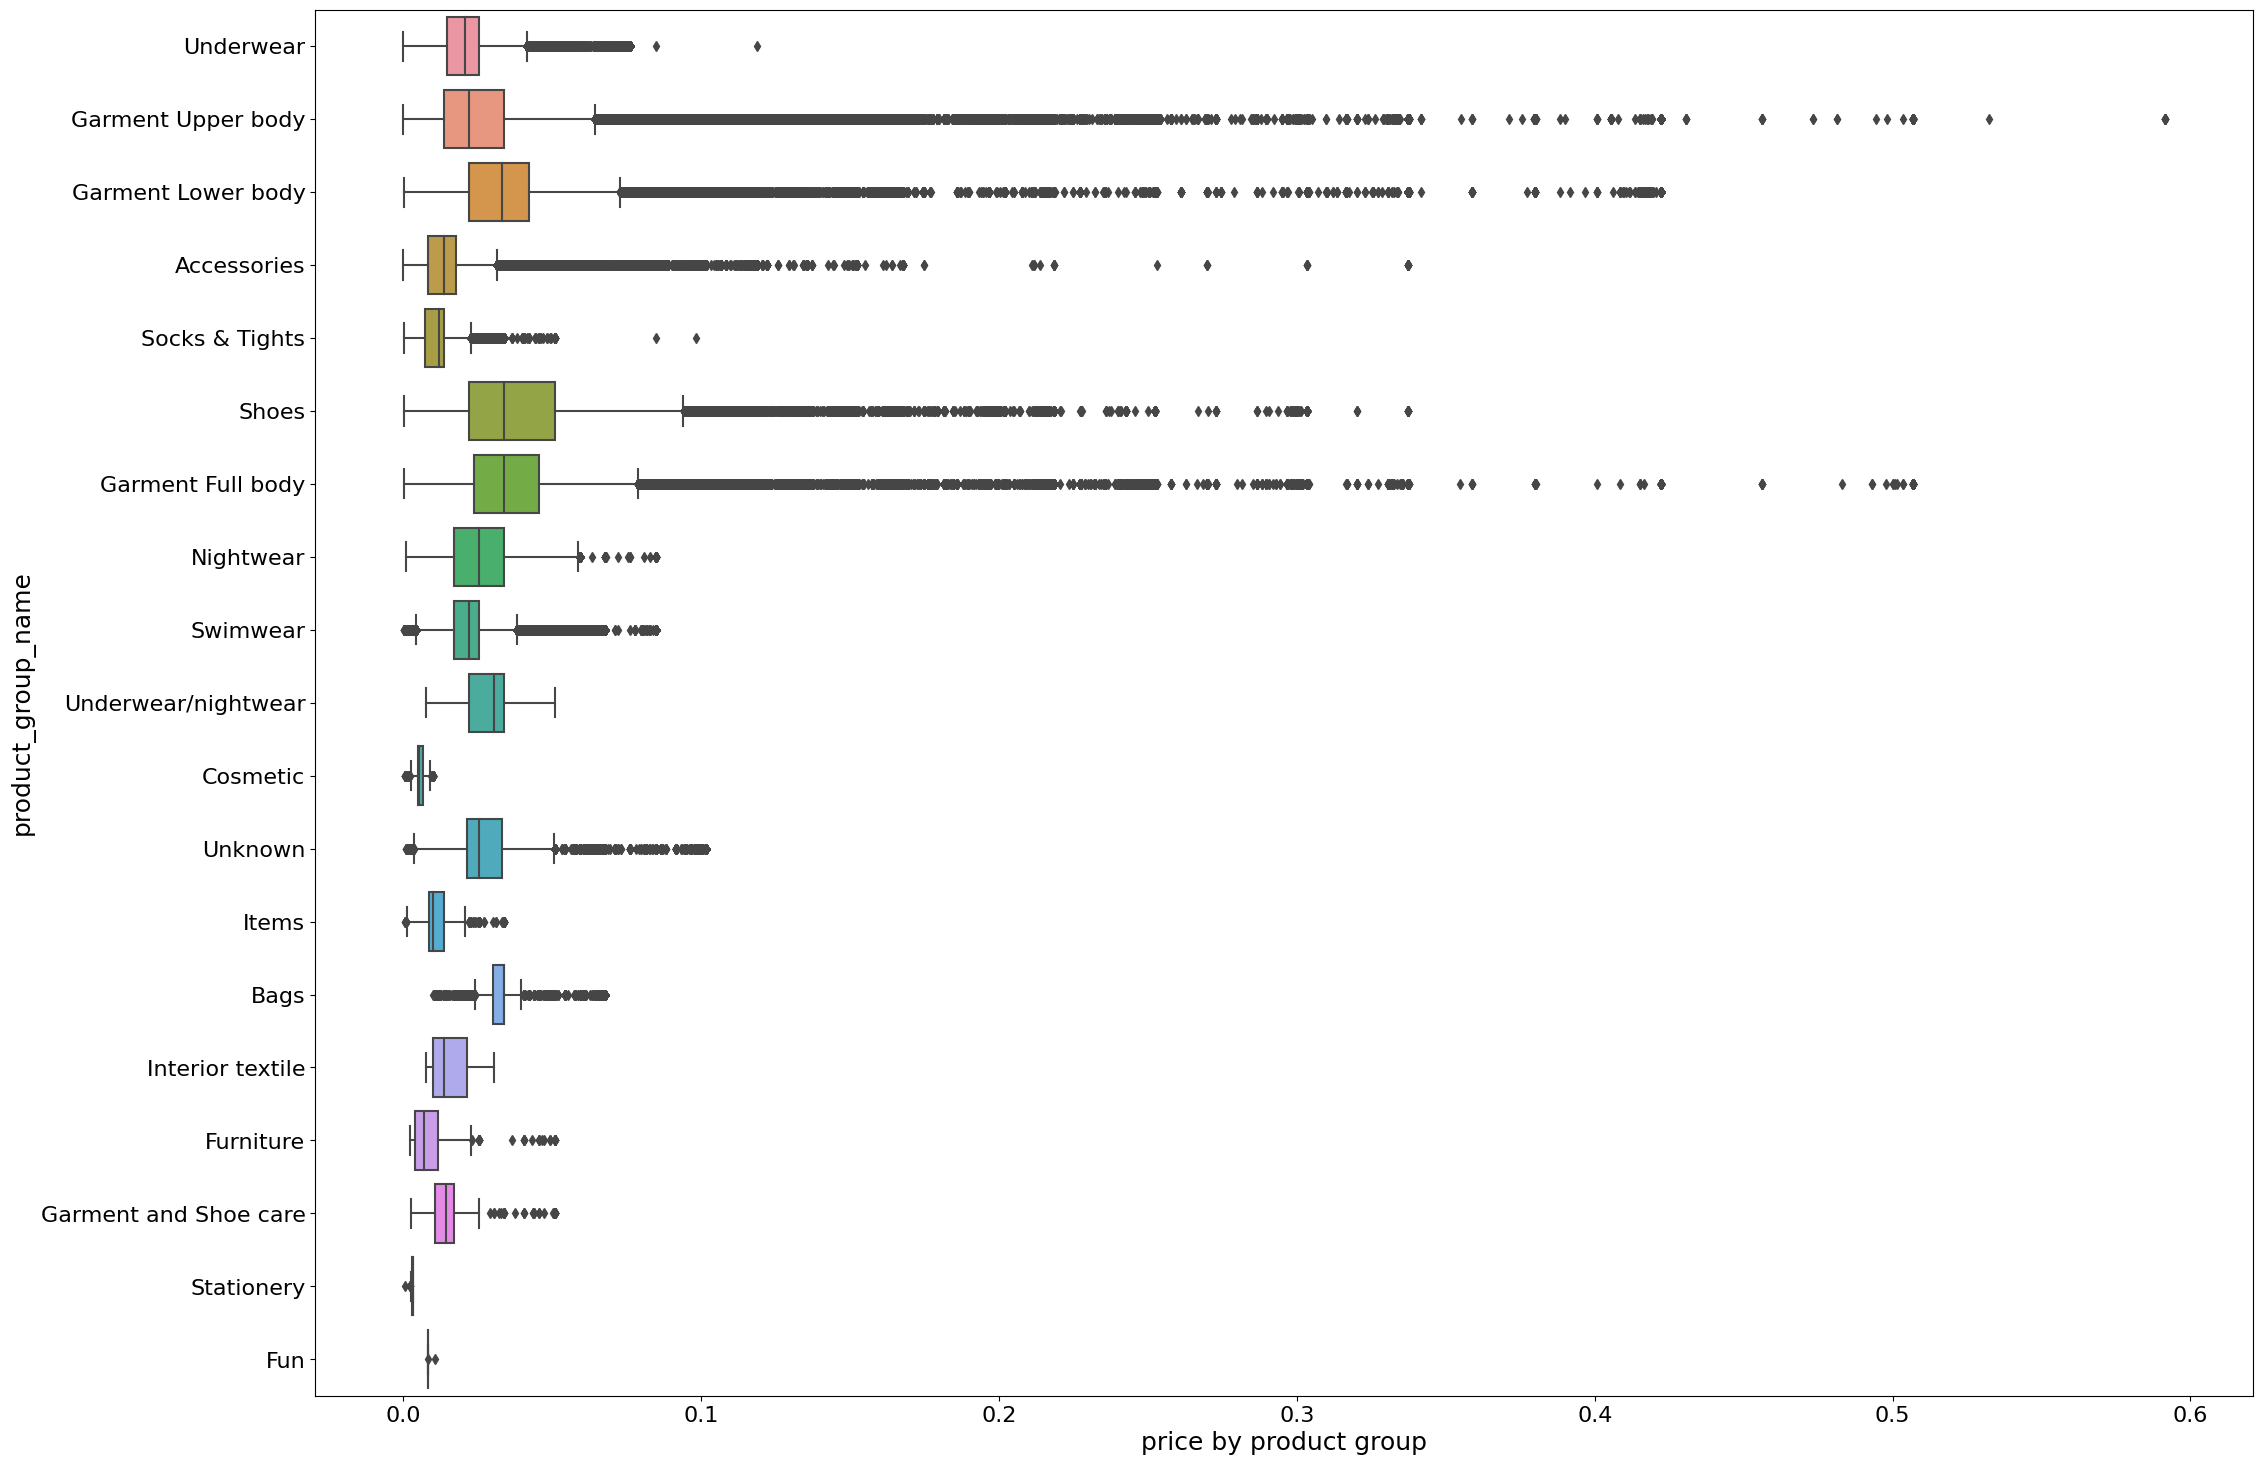

In [27]:
# Observing price distributions by product group 

# plot all boxplots
f, ax = plt.subplots(figsize=(25,18))
ax = sns.boxplot(data=merged_table_ta, x='price', y='product_group_name')
ax.set_xlabel('price by product group', fontsize=18)
ax.set_ylabel('product_group_name', fontsize=18)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
plt.show()

The prices for product groups Garment upper/lower/full and Shoes have a large variance in prices. The opposite is true for Cosmetic, Stationery and Fun product groups. <br> This is reasonable since the price can vary between different clothing collections of the same product group (Ex. premium full garmnet collection vs an on-sale garment collection).

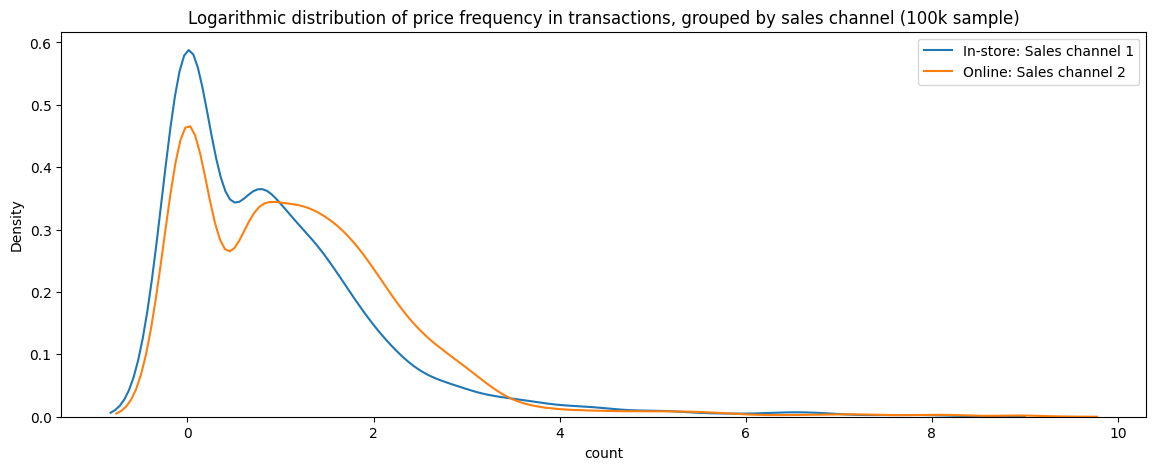

In [28]:
# Observing the distribution of price frequency in samples

# Sample 100,000 observations
merged_sample = merged_table_ta.sample(n=100000)

# using kdeplots to plot probability dist. of price values
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
sns.kdeplot(np.log(merged_sample.loc[merged_sample["sales_channel_id"]==1].price.value_counts()))
sns.kdeplot(np.log(merged_sample.loc[merged_sample["sales_channel_id"]==2].price.value_counts()))
ax.legend(labels=['In-store: Sales channel 1', 'Online: Sales channel 2'])
plt.title("Logarithmic distribution of price frequency in transactions, grouped by sales channel (100k sample)")
plt.show()


There is a slightly larger tendency for customers to purchase more expensive items online.

In [29]:
# Observing the top 10 customers by number of transactions

transactions['customer_id'].value_counts().head(10)

customer_id
 5854009424779598107    1895
 7398229172292340849    1441
 742206143892321423     1364
 3407358910964148684    1361
 1362310019195253974    1237
-4557035136527070563    1208
-4781325834093528838    1170
-6943172096873938826    1169
 1135991499650384534    1157
 8170076110479575893    1143
Name: count, dtype: int64

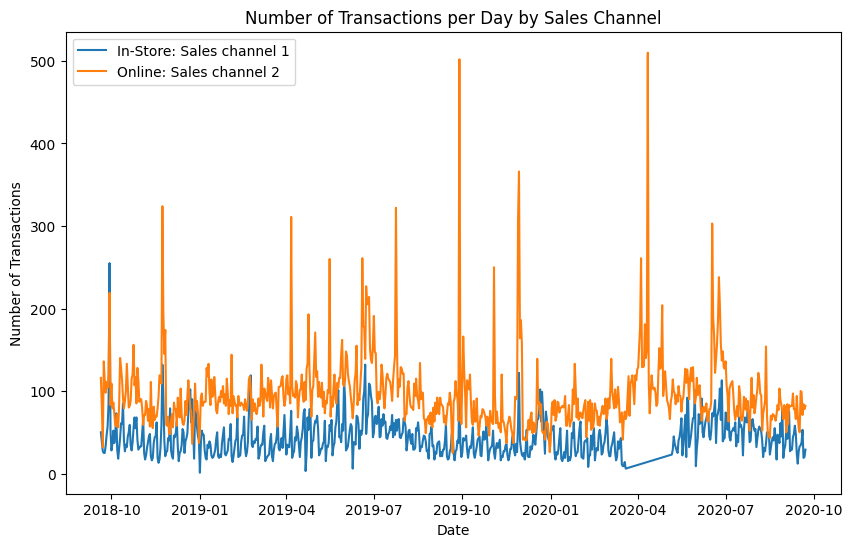

In [30]:
# Observing the number of transaction per day by sales channel

# Sample 100,000 observations
merged_table_ta_sample = merged_table_ta.sample(n=100000, random_state=69)

# Convert t_dat column to datetime format
merged_table_ta_sample['t_dat'] = pd.to_datetime(merged_table_ta_sample['t_dat'])

# Group the data by sales channel and date, and count the number of transactions for each group
transactions_by_day = merged_table_ta_sample.groupby(['sales_channel_id', pd.Grouper(key='t_dat', freq='D')])['article_id'].count()

# Create a line plot
fig, ax = plt.subplots(figsize=(10, 6))
for channel in transactions_by_day.index.levels[0]:
    if channel == 1:
        ax.plot(transactions_by_day[channel], label=f'In-Store: Sales channel 1')
    else:
        ax.plot(transactions_by_day[channel], label=f'Online: Sales channel 2')
ax.legend()
ax.set_title('Number of Transactions per Day by Sales Channel')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Transactions')
plt.show()


It is worth noting here that for April 2020, the number of in-store transactions is virtually nonexistent, while there is a sharp spike in online transactions for the same month; this is highly likely due to in-person stores possibly closing in April due to Covid-19.

In [31]:
# Purchase stats

num_unique_customers = len(transactions['customer_id'].unique())
num_unique_articles = len(transactions['article_id'].unique())
total_transactions = len(transactions)

print("Total H&M customers:", len(customers))
print("Total H&M articles:", len(articles))
print("Number of unique customers that purchased at least 1 article:", num_unique_customers)
print("Number of unique articles purchased:", num_unique_articles)
print("Number of customers that didn't make any transactions:", len(customers) - num_unique_customers)
print("Number of unique articles that weren't purchased:", len(articles) - num_unique_articles)
print("Total number of transactions:", total_transactions)

Total H&M customers: 1371980
Total H&M articles: 105542
Number of unique customers that purchased at least 1 article: 1362281
Number of unique articles purchased: 104547
Number of customers that didn't make any transactions: 9699
Number of unique articles that weren't purchased: 995
Total number of transactions: 31788324


In [32]:
# get % of customers that made at least 1 transaction in the last 3 months

transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])

# get the last transaction date for each customer
last_transaction_date = transactions.groupby('customer_id')['t_dat'].max()

three_months_ago = last_transaction_date.max() - pd.Timedelta(days=90)

# get the customers who made at least 1 transaction in the last 3 months
active_customers = last_transaction_date[last_transaction_date >= three_months_ago].index
percent_active_customers = len(active_customers) / len(last_transaction_date) * 100

print(f"Percentage of customers that made at least 1 transaction in the last 3 months: {percent_active_customers:.2f}%")



Percentage of customers that made at least 1 transaction in the last 3 months: 38.54%


In [33]:
# Validating that there are no duplicate customer or article IDs

duplicate_customers = customers[customers.duplicated(subset=['customer_id'], keep=False)]
duplicate_customers = duplicate_customers.sort_values(by=['customer_id'])
print("Number of non-unique customer IDs:", len(duplicate_customers))

duplicate_articles = articles[articles.duplicated(subset=['article_id'], keep=False)]
duplicate_articles = duplicate_articles.sort_values(by=['article_id'])
print("Number of non-unique article IDs:", len(duplicate_customers))


Number of non-unique customer IDs: 0
Number of non-unique article IDs: 0


There are 105 weeks of transaction data, with 31 million transactions. This is a lot of data to process - instead, we will use the the transaction data of the top 200 customers, based on the number of items they have bought in total. This will also help reduce the sparsity of any user-item interaction matrices we use.

<b>We will use an 80/20 time-based split for testing our data subset.</b>

## Models

Notes from the problem description:

"Your challenge is to predict what articles each customer will purchase in the 7-day period immediately after the training data ends. Customer who did not make any purchase during that time are excluded from the scoring."
    => `Predictions on 7 day period after the latest date found in the training data. The test week is the same for all customers, not one individual week per customer based on their latest training sample.`

- You will be making purchase predictions for all customer_id values provided, regardless of whether these customers made purchases in the training data.
- Customer that did not make any purchase during test period are excluded from the scoring.
- There is never a penalty for using the full 12 predictions for a customer that ordered fewer than 12 items; thus, it's advantageous to make 12 predictions for each customer.

-------------------------------------------------------------------------------------------------------------------------
As per the given evaluation metric `MAP@12`, since the rank = 12, we have to recommend the top 12 products (sorted by recommendation score), each customer would likely purchase.

We will be using 1 baseline popularity model and 5 different models that utilize `collaborative filtering` to make recommendations, and evaluate each model's performance using the MAP@12 metric. 

The 5 different models are: ALS, SGD, LightGBM, CatBoost and a GNN. 

Since the dataset has no `explicit feedback` from customers (ex. ratings, reviews), we can consider the quantity of each item a customer purchased as an indicator of purchase preference, or a binary indicator of whether an item was purchased - either of these strategies will act as our `implicit feedback`. 

The primary goal of this recommender system, and product-based recommender systems in general, is to `recommend articles the user is likely to be interested in`. Quantity of an article may not always be indicator of interest in an item, especially if the item bought usually requires multiple amounts of the item purchased, or if the item purchased is a gift. However, a normalized purchase quantity will weight the user-item interaction matrix, and thus could potentially provide more information to the recommender system. 

Additionally, one could also incorporate the price of an item and purchase recency as part of the implicit feedback, as buying an expensive item could potentially be a stronger indicator of item preferences vs. buying large quantities of cheaper items. 